In [14]:
# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
import torch.nn.functional as F
#Image
from PIL import Image
from skimage import io, transform
from IPython.display import display
import matplotlib.pyplot as plt
from torchvision import transforms
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to download the dataset
import torchvision.datasets as dsets
# Used to graph data and loss curves
import matplotlib.pyplot as plt
import string
# Allows us to use arrays to manipulate and store data
import numpy as np
import random
import seaborn
from torchvision import models
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import math
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add, Input, Dropout, Dense, concatenate, Embedding,LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:
resnext101=models.resnet.resnext101_32x8d(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


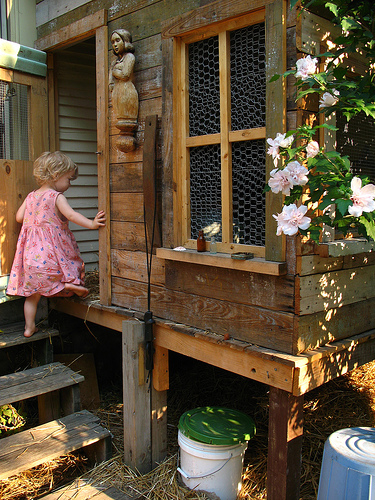

In [16]:
#Sample Image from the Flickr8k Dataset
img=Image.open('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg')
img

In [17]:
#Defining transform to get our image to its requirements provided by the ResNext101 Model
transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229, 0.224, 0.225])])

In [18]:
img_t=transform(img)
img_t.shape

torch.Size([3, 224, 224])

In [19]:
#Checking out ResNext101 for the image
batch_t=torch.unsqueeze(img_t,0)

resnext101.eval()

out = resnext101(batch_t)

#Classes.txt not used in the model, just used to check out ResNext101 predictions
with open('/kaggle/input/imagenet-classestxt/imagenet-classes.txt') as f:
    classes=[line.strip() for line in f.readlines()]

#Percentage Classification for the 1000 classes of image net
_,indices = torch.sort(out, descending=True)
percentage= torch.nn.functional.softmax(out,dim=1)[0]*100
[(classes[idx],percentage[idx].item()) for idx in indices[0][:10]]

[('apiary, bee house', 52.16262435913086),
 ('yurt', 41.7625846862793),
 ('honeycomb', 1.327736258506775),
 ('mobile home, manufactured home', 0.5176102519035339),
 ('greenhouse, nursery, glasshouse', 0.46617215871810913),
 ('thatch, thatched roof', 0.39590632915496826),
 ('overskirt', 0.2568483054637909),
 ('patio, terrace', 0.21178367733955383),
 ('rain barrel', 0.18614442646503448),
 ('bee', 0.17982156574726105)]

In [20]:
#Converting our txt captions file to a csv file
data = pd.read_csv('/kaggle/input/flickr8k/captions.txt')
data

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [21]:
def preprocess_caption(caption):
    punct_table = str.maketrans("", "", string.punctuation)
    # Extract separate tokens
    caption = caption.split()
    # Make tokens lowercase
    caption = [word.lower() for word in caption]
    # Remove punctuation
    caption = [word.translate(punct_table) for word in caption]
    # Remove single letters
    caption = [word for word in caption if len(word) > 1]
    # Remove numbers
    caption = [word for word in caption if word.isalpha()]
    return " ".join(caption)


In [22]:
# Perfromed the preprocessing on the entire dataset
minl=1000
maxl=-1
for i,caption in enumerate(data['caption']):
    caption=preprocess_caption(caption)
    minl=min(minl,len(caption.split()))
    maxl=max(maxl,len(caption.split()))
    data['caption'][i]=caption
print(maxl,minl)
data

32 0


,image,caption
0,1000268201_693b08cb0e.jpg,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e.jpg,girl going into wooden building
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,little girl in pink dress going into wooden cabin
...,...,...
40450,997722733_0cb5439472.jpg,man in pink shirt climbs rock face
40451,997722733_0cb5439472.jpg,man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,person in red shirt climbing up rock face cove...
40453,997722733_0cb5439472.jpg,rock climber in red shirt


In [23]:
#defining a dictionary containing all the captions for the key(image)
image_captions=dict()
list_of_captions=[]
count=0
for image in data['image'].unique():
    key=image.split(".")[0]
    
    image_captions[key]=[]
    for caption in (data.loc[data['image']==image]['caption']):
        
        #we only will append the captions whose length is more than 1, have a one word caption does not make sense
        if(len(caption.split()) >=2):
            
            #tokens for SOS and EOS
            caption='startseq ' + caption + ' endseq'
            list_of_captions.append(caption)
            image_captions[key].append(caption)
    if(len(image_captions[key]) !=5):
        count=count+1
image_captions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

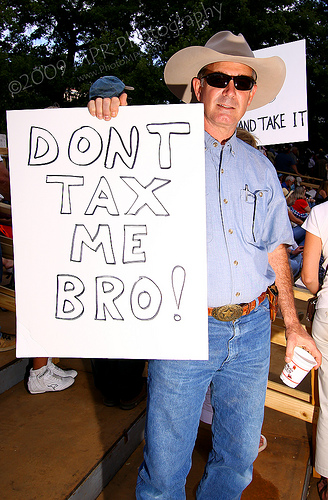

startseq man holding political sign endseq
startseq man in jeans cowboy hat holds up sign endseq
startseq man wearing cowboy hat holding protest sign endseq
startseq man with cowboy hat and an antitax sign endseq
startseq protester in cowboy gear holds up sign that says dont tax me bro endseq


In [24]:
random_key = random.choice(list(image_captions.keys()))
imgrandom = Image.open(f'/kaggle/input/flickr8k/Images/{random_key}.jpg')
imgrandomt= transform(imgrandom)
display(imgrandom)
for caption in image_captions[random_key]:
    print(caption)

In [25]:
#Function used for feature extraction
def get_activation(name):
    def hook(resnext101, input, output):
            activation[name] = output.detach()
    return hook

In [160]:

feature_vectors=dict()
idx=1
for image in image_captions.keys():
    imgf = Image.open(f'/kaggle/input/flickr8k/Images/{image}.jpg')
    imgft=transform(imgf)
    batch_ft=torch.unsqueeze(imgft,0)
    activation={}
    resnext101.avgpool.register_forward_hook(get_activation('feats'))
    out=resnext101(batch_ft)
    feature_vectors[image]=activation['feats']
    idx+=1
    print(idx)
    


2
3
4
5
6
7
8
9
10
11
12
13
14
15


KeyboardInterrupt: 

In [14]:
for key,value in feature_vectors.items():
    feature_vectors[key]=value.view(1,2048)

NameError: name 'feature_vectors' is not defined

In [15]:
# import json

# # Save the dictionary to a file
# with open("feature_vectors.json", "w") as file:
#     json.dump(feature_vectors, file)

# file_path = 'feature_dict.pt'

# # Save the dictionary
# torch.save(feature_vectors, file_path)

NameError: name 'feature_vectors' is not defined

In [26]:
file_path = '/kaggle/input/resnext-featuredict/feature_dict.pt'
feature_vectors = torch.load(file_path)
resnext_vectors={}
for key in feature_vectors.keys():
    resnext_vectors[key]=feature_vectors[key].squeeze().numpy()
resnext_vectors[random_key].shape

(2048,)

In [51]:
resnext_vectors

{'1000268201_693b08cb0e': array([0.41483408, 0.30994266, 0.20559707, ..., 1.0485567 , 0.62248164,
        0.2305698 ], dtype=float32),
 '1001773457_577c3a7d70': array([0.24473463, 0.07321131, 0.44197923, ..., 0.14672013, 0.07235833,
        0.09344602], dtype=float32),
 '1002674143_1b742ab4b8': array([1.18948   , 0.77266496, 0.19925232, ..., 0.6848411 , 0.0735494 ,
        0.01375776], dtype=float32),
 '1003163366_44323f5815': array([0.2674609 , 0.22455402, 1.4120687 , ..., 0.05623998, 0.47578722,
        0.508964  ], dtype=float32),
 '1007129816_e794419615': array([0.53557354, 0.57915074, 0.33101562, ..., 0.06215987, 0.22928023,
        0.43198952], dtype=float32),
 '1007320043_627395c3d8': array([0.3283953 , 0.57531154, 2.1550775 , ..., 0.98386353, 0.3689274 ,
        0.13190773], dtype=float32),
 '1009434119_febe49276a': array([0.07097446, 0.09840499, 0.95871025, ..., 0.02765914, 0.24498282,
        0.07762825], dtype=float32),
 '1012212859_01547e3f17': array([0.7289108 , 0.3688508 

In [27]:
#Splitting of dataset into Training,Validation,Testing (4:1:1)
keys = list(image_captions.keys())
values =list(image_captions.values())

# Split the keys and values into train, validation, and test sets
train_keys, remaining_keys, train_values, remaining_values = train_test_split(keys, values, test_size=0.2, random_state=42)
val_keys, test_keys, val_values, test_values = train_test_split(remaining_keys, remaining_values, test_size=0.5, random_state=42)

# Create train, validation, and test dictionaries
train_dict = {k: v for k, v in zip(train_keys, train_values)}
val_dict = {k: v for k, v in zip(val_keys, val_values)}
test_dict = {k: v for k, v in zip(test_keys, test_values)}

In [28]:
print("Length of training Dictionary:", len(train_dict))
print("Length of validation Dictionary:", len(val_dict))
print("Length of testing Dictionary:", len(test_dict))

Length of training Dictionary: 6472
Length of validation Dictionary: 809
Length of testing Dictionary: 810


In [29]:
trainlist_captions = []
vallist_captions=[]
# List of all captions
for captions in train_dict.values():
    for caption in captions:
        trainlist_captions.append(caption)
for captions in val_dict.values():
    for caption in captions:
        vallist_captions.append(caption)


In [30]:
#Vocabulary list of our dataset
def vocab(text):
    vocab_list=set()
    for caption in text:
        words=caption.split()
        for word in words:
            vocab_list.add(word)
    return vocab_list

vocab_list=vocab(list_of_captions)
print(len(vocab_list))

8765


In [31]:
#tokenize all of the captions
inttoword=dict()
wordtoint=dict()
idx=3
inttoword[1]='startseq'
wordtoint['startseq']=1
inttoword[2]='endseq'
wordtoint['endseq']=2
inttoword[0]=''
wordtoint['']=0

for word in vocab_list:
    if word=='startseq' or word=='endseq':
        continue
    inttoword[idx]=word
    wordtoint[word]=idx
    idx+=1

In [32]:
def numericalize(dict):
    numerical_captions={}
    for image, captions in dict.items():
        numerical_captions[image] = []
        for caption in captions:
            # Split the caption into words
            words = caption.split()
            # Numericalize the words using the word_to_int dictionary
            for x in words:
                if x not in wordtoint:
                    print("A problem")
                    
            numerical_caption = [wordtoint[word] for word in words]
            # Append the numericalized caption to the list
            numerical_captions[image].append(numerical_caption)
    return numerical_captions

In [33]:
train_n_dict=numericalize(train_dict)
val_n_dict = numericalize(val_dict)
train_n_dict


{'3393152604_27bd1037f2': [[1, 5177, 3354, 3527, 5625, 744, 2305, 7985, 2],
  [1,
   7647,
   8220,
   2010,
   3452,
   8069,
   5625,
   1405,
   7985,
   2887,
   3071,
   7225,
   5009,
   1340,
   2],
  [1, 4137, 8568, 2483, 7647, 7106, 2732, 2225, 2],
  [1, 3252, 4137, 8568, 2483, 7647, 3354, 3629, 5625, 3254, 7898, 2],
  [1, 3252, 7647, 7421, 5009, 3252, 2209, 5625, 2]],
 '3549673305_4dfd44e04a': [[1,
   177,
   2673,
   5156,
   3252,
   1326,
   5156,
   7629,
   5979,
   2],
  [1, 1617, 7860, 5140, 5156, 2959, 5979, 2],
  [1,
   1617,
   2887,
   8726,
   7224,
   5009,
   3252,
   8049,
   2507,
   5588,
   3252,
   1326,
   6213,
   5140,
   2887,
   5165,
   2485,
   10,
   2483,
   2738,
   2],
  [1, 1617, 5588, 4835, 5156, 1326, 2],
  [1, 1617, 2673, 5140, 1326, 5156, 7629, 3275, 2]],
 '3181328245_7c04ce1691': [[1, 4331, 5133, 2576, 2289, 2887, 2999, 860, 2],
  [1, 4331, 5133, 1145, 3144, 6213, 6968, 396, 1964, 2],
  [1, 4331, 4336, 3349, 3144, 2999, 7225, 2],
  [1, 4331

In [79]:
# tokenizer = Tokenizer()
# # Assigns unqiue integer to every word
# tokenizer.fit_on_texts(list_of_captions)
# #vocabulary size
# vocab_size = len(tokenizer.word_index) + 1 
# #maximum length of a caption
# max_len = max(len(d.split()) for d in list_of_captions) 

# print("Vocab Size:",vocab_size)
# print("Maximum length of preprocessed captions:", max_len)

Vocab Size: 8766
Maximum length of preprocessed captions: 34


In [34]:
vocab_size=8766
max_len=34
print(len(train_n_dict),len(val_n_dict),len(test_dict))

6472 809 810


In [35]:
def data_loader(features,dict,batch_size,max_len):
    inpcnn=[]
    inprnn=[]
    output=[]
    cnt=0
    while True:
        for key, captions in dict.items():
            cnt+=1
            pic = resnext_vectors[key]
            for cap in captions:
                seq = cap
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    
                    inpcnn.append(pic)
                    inprnn.append(in_seq)
                    output.append(out_seq)
                    # store
            if cnt==batch_size:
                yield [np.array(inpcnn), np.array(inprnn)], np.array(output)
                inpcnn=[]
                inprnn=[]
                output=[]
                cnt=0

In [36]:
# feature extractor model
inpcnn = Input(shape=(2048,))
dropout1 = Dropout(0.5)(inpcnn)
linear1 = Dense(256, activation='relu')(dropout1)

# sequence model (the two parallel paths)
inprnn = Input(shape=(max_len,))
embedding = Embedding(vocab_size, 256, mask_zero=True)(inprnn)
dropout2 = Dropout(0.5)(embedding)
lstm = LSTM(256)(dropout2)

# decoder model
adder = add([linear1, lstm])
linear2 = Dense(256, activation='relu')(adder)
outputs = Dense(vocab_size, activation='softmax')(linear2)

# THE MODEL
image_captioner = Model(inputs=[inpcnn, inprnn], outputs=outputs)
image_captioner.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(image_captioner.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      2244096     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

In [37]:
def train_model(model,batch_size,epochs):
    batch_size = batch_size
    epochs = epochs
    steps = math.ceil(len(train_dict) / batch_size)
    for i in range(epochs):
        print(f'Epoch {i+1}')
        train_loader = data_loader(resnext_vectors, train_n_dict, batch_size, max_len)
        val_loader = data_loader(resnext_vectors, val_n_dict, batch_size, max_len)
        model.fit(train_loader, epochs=1, steps_per_epoch=steps, verbose=1)

In [49]:
train_model(image_captioner,32,5)

Epoch 1
203/203 [==============================] - 81s 372ms/step - loss: 5.8695
Epoch 2
203/203 [==============================] - 58s 288ms/step - loss: 4.5478
Epoch 3
203/203 [==============================] - 59s 293ms/step - loss: 4.2320
Epoch 4
203/203 [==============================] - 59s 292ms/step - loss: 4.0640
Epoch 5
203/203 [==============================] - 59s 291ms/step - loss: 3.9499


In [50]:
train_model(image_captioner,32,5)

Epoch 1
203/203 [==============================] - 59s 289ms/step - loss: 3.8619
Epoch 2
203/203 [==============================] - 59s 290ms/step - loss: 3.7859
Epoch 3
203/203 [==============================] - 58s 288ms/step - loss: 3.7194
Epoch 4
203/203 [==============================] - 59s 290ms/step - loss: 3.6594
Epoch 5
203/203 [==============================] - 59s 292ms/step - loss: 3.6026


In [51]:
train_model(image_captioner,32,5)

Epoch 1
203/203 [==============================] - 58s 287ms/step - loss: 3.5504
Epoch 2
203/203 [==============================] - 58s 287ms/step - loss: 3.5018
Epoch 3
203/203 [==============================] - 58s 287ms/step - loss: 3.4592
Epoch 4
203/203 [==============================] - 59s 289ms/step - loss: 3.4115
Epoch 5
203/203 [==============================] - 59s 292ms/step - loss: 3.3656


In [52]:
train_model(image_captioner,32,5)

Epoch 1
203/203 [==============================] - 59s 288ms/step - loss: 3.3153
Epoch 2
203/203 [==============================] - 59s 291ms/step - loss: 3.2669
Epoch 3
203/203 [==============================] - 60s 297ms/step - loss: 3.2226
Epoch 4
203/203 [==============================] - 59s 291ms/step - loss: 3.1789
Epoch 5
203/203 [==============================] - 59s 291ms/step - loss: 3.1336


In [60]:
train_model(image_captioner,32,5)

Epoch 1
203/203 [==============================] - 60s 296ms/step - loss: 2.7236
Epoch 2
203/203 [==============================] - 60s 293ms/step - loss: 2.6949
Epoch 3
203/203 [==============================] - 60s 292ms/step - loss: 2.6662
Epoch 4
203/203 [==============================] - 60s 295ms/step - loss: 2.6419
Epoch 5
203/203 [==============================] - 61s 299ms/step - loss: 2.6159


In [108]:
# image_captioner.save('ic2.h5')

In [45]:
image_captioner = load_model('/kaggle/input/weights/ic2.h5')

**Generating Captions: Beam Search**

In [61]:
#expects image in the Image.open form
def captioner(model, feature, max_len):
    start_token=[1]
    end_token=[2]
    beam_index=3
    
    start_word = [[start_token, 0.0]]
    
    while len(start_word[0][0]) < max_len+1:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_len)
            
            preds = model.predict([feature, np.array(par_caps)],verbose=0)
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [inttoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [62]:
def featureextraction(image):
    def get_activation(name):
        def hook(resnext101, input, output):
            activation[name] = output.detach()
        return hook
    batch_image=torch.unsqueeze(image,0)
    activation={}
    resnext101.avgpool.register_forward_hook(get_activation('feat'))
    out=resnext101(batch_image)
    featureex=activation['feat']
    featureex=featureex.squeeze().numpy()
    featureex = np.expand_dims(featureex, axis=0)
    return featureex

Predicted: two brown dogs are running through the grass


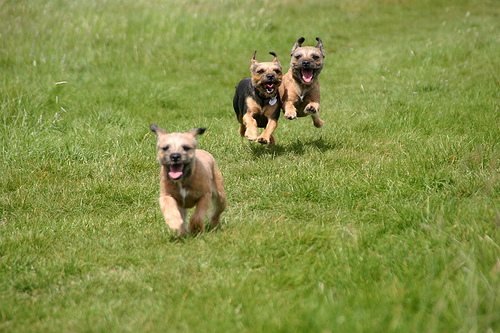

startseq three brown puppies running in the grass endseq
startseq three dogs are running through the grass endseq
startseq three dogs run through field endseq
startseq three small puppies run through the green grass endseq
startseq three tan and brown dogs are running over grass endseq


In [63]:
random_key = random.choice(list(train_dict.keys()))
imgrandom = Image.open(f'/kaggle/input/flickr8k/Images/{random_key}.jpg')
imgrandomt= transform(imgrandom)

featureex = featureextraction(imgrandomt)

print("Predicted:",captioner(image_captioner,featureex,max_len))
display(imgrandom)
for caption in image_captions[random_key]:
    print(caption)

**BLEU Evaluation Analysis**

In [64]:
#Let us try BLEU on some random images firstly
def bleueval(model):
    transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229, 0.224, 0.225])])
    random_key = random.choice(list(train_dict.keys()))
    imgrandom = Image.open(f'/kaggle/input/flickr8k/Images/{random_key}.jpg')
    imgrandomt= transform(imgrandom)
    featureex = featureextraction(imgrandomt)
    predicted_caption=captioner(model,featureex,max_len)
    display(imgrandom)
    print("Predicted:",predicted_caption)
    reference=[]
    for caption in image_captions[random_key]:
        print(caption.split())
        reference_caption=' '.join(caption.split()[1:-1])
        reference.append(reference_caption.split())
    bleu_1=(sentence_bleu(reference, predicted_caption.split(), weights=(1, 0, 0, 0)))
    # Calculate BLEU-2 score (bigram)
    bleu_2=(sentence_bleu(reference, predicted_caption.split(), weights=(0.5, 0.5, 0, 0)))
    # Calculate BLEU-3 score (trigram)
    bleu_3=(sentence_bleu(reference, predicted_caption.split(), weights=(0.33, 0.33, 0.33, 0)))
    bleu_4=(sentence_bleu(reference, predicted_caption.split(), weights=(0.25, 0.25, 0.25, 0.25)))
   
    print("BLEU-1:", (bleu_1))
    print("BLEU-2:", (bleu_2))
    print("BLEU-3:", (bleu_3))
    print("BLEU-4:", (bleu_4))

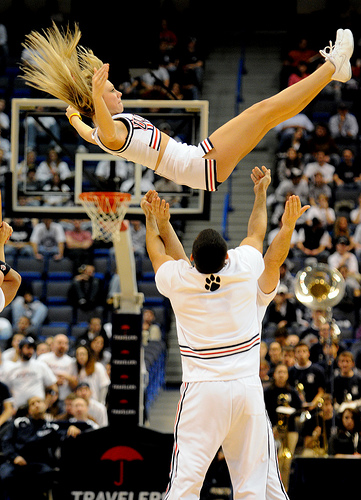

Predicted: the basketball player in white and white uniform is in front of crowd
['startseq', 'cheerleading', 'squad', 'performing', 'in', 'front', 'of', 'an', 'audience', 'endseq']
['startseq', 'cheerleaders', 'are', 'performing', 'in', 'gym', 'endseq']
['startseq', 'the', 'two', 'men', 'throw', 'the', 'cheerleader', 'in', 'the', 'air', 'endseq']
['startseq', 'two', 'male', 'cheerleaders', 'are', 'catching', 'girl', 'cheerleader', 'in', 'the', 'air', 'endseq']
['startseq', 'two', 'men', 'throw', 'cheerleader', 'into', 'the', 'air', 'and', 'then', 'catch', 'her', 'endseq']
BLEU-1: 0.38461538461538464
BLEU-2: 0.25318484177091666
BLEU-3: 0.1830666761913796
BLEU-4: 0.27629350710622463


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [65]:
bleueval(image_captioner)

In [68]:
def evaluate_model(model, dictionary, max_len):
    actual_captions, predicted_captions = [], []

    for image, captions in dictionary.items():
        img = Image.open(f'/kaggle/input/flickr8k/Images/{image}.jpg')
        imgt= transform(img)
        featureex = featureextraction(imgrandomt)
        
        actual_captions.append([caption.split()[1:-1] for caption in captions])
        predicted_captions.append(captioner(model,featureex,max_len))

     # BLEU score
    print("BLEU-1:", corpus_bleu(actual_captions, predicted_captions, weights=(1.0, 0, 0,0)))
    print("BLEU-2:", corpus_bleu(actual_captions, predicted_captions, weights=(0.5, 0.5,0,0)))
    print("BLEU-3:", corpus_bleu(actual_captions, predicted_captions, weights=(0.33,0.33,0.33,0)))
    print("BLEU-4:", corpus_bleu(actual_captions, predicted_captions, weights=(0.25, 0.25,0.25,0.25)))


In [ ]:
evaluate_model(image_captioner,test_dict,max_len)